# [V3] Couple Candlesticks - Strategy - Backtesting 

In [42]:
# Switch Deal

### Import Library

In [43]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [44]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [45]:
data = dataset.copy()

In [46]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [47]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [48]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond

def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] == r['Low'] and r['Low'] < r['prev_low']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] == r['High']  and r['High'] > r['prev_high']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond

def get_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [49]:
def prepare_data(data):
    data["current"] = data.index + pd.DateOffset(minutes=5)
    data['prev_low'] = data['Low'].shift(1)
    data['prev_high'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    adx = ta.adx(data['High'], data['Low'], data['Close'], length = 42)
    data = data.assign(ADX=adx['ADX_42'])
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    data['ADX'] = round(data['ADX'])
    data['RSI'] = ta.rsi(data["Close"], length=14)
    data['RSI'] = round(data['RSI'])
    data["ATR_14"] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
    data['Close_s1'] = data['Close'].shift(1)
    data['price_move'] = data.apply(lambda r: (r['Close'] - r['Close_s1']) - 0.5 * r['ATR_14'] , axis=1)
    data['price_move'] = round(data['price_move'])
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['diff_cema'] = data['Close'] - data['ema_low']
    data['diff_cema'] = round(data['diff_cema'])
    data['range_to_min5'] = data['Close'] - data['min_5']
    data['range_to_min5'] = round(data['range_to_min5'], 1)
    data['range_to_max5'] = data['max_5'] - data['Close']
    data['range_to_max5'] = round(data['range_to_max5'], 1)
    return data

In [50]:
class CoupleCandlesticks(Strategy):
    max_sl = 3.5
    trailing_sl = 7.5
    tp_step = 30
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return
                
        if current_time.hour == 14 and current_time.minute >= 30:
            return

        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_5 = self.data.max_5[-1]
            if close_price < max_5 - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_5 = self.data.min_5[-1]
            if close_price > min_5 + self.trailing_sl:
                self.position.close()

        if self.position:
            return  
        signal = self.data.signal[-1]
        if signal == 'long':
            buy_price = close_price
            min_5 = self.data.min_5[-1]
            tmp_risk = buy_price - min_5
            risk = min(tmp_risk, self.max_sl)
            sl = buy_price - risk
            tp = buy_price + self.tp_step
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            sell_price = close_price
            max_5 = self.data.max_5[-1]
            tmp_risk = max_5 - sell_price
            risk = min(tmp_risk, self.max_sl)
            sl = sell_price + risk
            tp = sell_price - self.tp_step
            self.sell(size=1, sl=sl, tp=tp)

In [51]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [52]:
# prepared_data[(prepared_data.index > '2024-11-05 00:00:00') & (prepared_data.index < '2024-11-05 15:00:00')]

In [53]:
bt = Backtest(prepared_data, CoupleCandlesticks, commission=.0003, exclusive_orders=True)
stats = bt.run()
# bt.plot()
print(stats)

Start                     2020-11-06 14:10:00
End                       2025-02-07 14:45:00
Duration                   1554 days 00:35:00
Exposure Time [%]                   33.915669
Equity Final [$]                   2232.67428
Equity Peak [$]                    2255.16051
Return [%]                          48.844952
Buy & Hold Return [%]               47.453348
Return (Ann.) [%]                    9.917057
Volatility (Ann.) [%]                6.902337
Sharpe Ratio                         1.436768
Sortino Ratio                        3.148327
Calmar Ratio                         2.013505
Max. Drawdown [%]                    -4.92527
Avg. Drawdown [%]                   -0.334563
Max. Drawdown Duration      370 days 00:30:00
Avg. Drawdown Duration        5 days 20:50:00
# Trades                                 1621
Win Rate [%]                         35.34855
Best Trade [%]                       2.295959
Worst Trade [%]                     -0.920813
Avg. Trade [%]                    

In [54]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,27,48,919.17567,917.2,-1.97567,-0.002149,2020-11-09 10:45:00,2020-11-09 13:55:00,None,0 days 03:10:00
1,1,76,78,929.97891,928.1,-1.87891,-0.002020,2020-11-10 10:35:00,2020-11-10 10:45:00,None,0 days 00:10:00
2,-1,112,131,920.82367,922.6,-1.77633,-0.001929,2020-11-11 09:20:00,2020-11-11 10:55:00,None,0 days 01:35:00
3,-1,137,156,918.72430,919.5,-0.77570,-0.000844,2020-11-11 11:25:00,2020-11-11 14:25:00,None,0 days 03:00:00
4,-1,183,199,923.52286,925.8,-2.27714,-0.002466,2020-11-12 11:00:00,2020-11-12 13:45:00,None,0 days 02:45:00
...,...,...,...,...,...,...,...,...,...,...,...
1616,1,53821,53823,1330.89915,1328.5,-2.39915,-0.001803,2025-02-04 14:20:00,2025-02-04 14:30:00,None,0 days 00:10:00
1617,1,53838,53849,1335.60056,1333.4,-2.20056,-0.001648,2025-02-05 10:05:00,2025-02-05 11:00:00,None,0 days 00:55:00
1618,-1,53860,53866,1331.20052,1332.6,-1.39948,-0.001051,2025-02-05 13:20:00,2025-02-05 13:50:00,None,0 days 00:30:00
1619,1,53867,53874,1333.90005,1335.1,1.19995,0.000900,2025-02-05 13:55:00,2025-02-05 14:30:00,None,0 days 00:35:00


In [55]:
trades = stats['_trades']

In [56]:
trades['cum_sum'] = trades['PnL'].cumsum()
X = np.array(range(0, len(trades['cum_sum'])))
Y = trades['cum_sum']

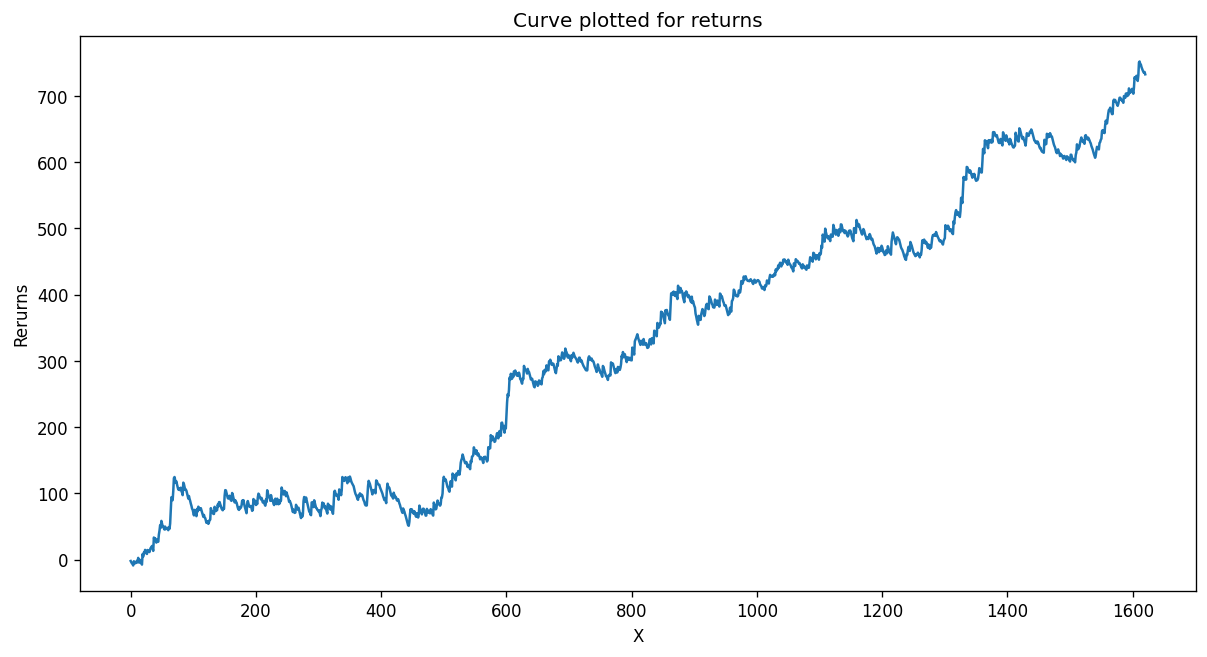

In [57]:
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [75]:
trades['PnL'].sum()

732.6742800000553

In [58]:
join_trades = pd.merge(trades, prepared_data, left_on="EntryTime", right_on='current', how="left")
join_trades.tail(30)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,ADX,signal,RSI,ATR_14,Close_s1,price_move,ema_low,diff_cema,range_to_min5,range_to_max5
1591,1,52827,52838,1351.70539,1347.8,-3.90539,-0.002889,2024-12-31 10:15:00,2024-12-31 11:10:00,None,...,16.0,long,69.0,1.034866,1349.2,1.0,1344.549623,7.0,3.3,0.0
1592,-1,52868,52905,1348.19542,1344.0,4.19542,0.003112,2025-01-02 10:00:00,2025-01-02 14:30:00,None,...,11.0,short,55.0,1.221236,1349.9,-2.0,1345.486075,3.0,0.8,2.5
1593,1,52927,52930,1340.30197,1337.4,-2.90197,-0.002165,2025-01-03 10:40:00,2025-01-03 10:55:00,None,...,16.0,long,46.0,1.124356,1338.6,1.0,1343.807398,-4.0,2.4,0.0
1594,-1,52931,52956,1336.69887,1326.4,10.29887,0.007705,2025-01-03 11:00:00,2025-01-03 14:30:00,None,...,17.0,short,35.0,1.149564,1338.7,-2.0,1343.651728,-7.0,0.0,3.4
1595,-1,52972,52974,1327.10175,1329.9,-2.79825,-0.002109,2025-01-06 10:10:00,2025-01-06 10:20:00,None,...,30.0,short,48.0,1.457915,1328.4,-1.0,1339.516103,-12.0,1.1,2.2
1596,-1,52985,52994,1324.10265,1328.0,-3.89735,-0.002943,2025-01-06 11:15:00,2025-01-06 13:25:00,None,...,27.0,short,34.0,1.299552,1325.7,-2.0,1338.401577,-14.0,0.0,4.1
1597,-1,52998,53007,1325.00238,1321.2,3.80238,0.002870,2025-01-06 13:45:00,2025-01-06 14:30:00,None,...,25.0,short,40.0,1.222601,1326.5,-2.0,1337.199309,-12.0,0.0,3.5
1598,-1,53032,53035,1322.90301,1324.9,-1.99699,-0.001510,2025-01-07 10:55:00,2025-01-07 11:10:00,None,...,19.0,short,49.0,1.207341,1324.5,-2.0,1333.913617,-11.0,1.2,1.5
1599,-1,53048,53058,1323.90271,1319.7,4.20271,0.003174,2025-01-07 13:40:00,2025-01-07 14:30:00,None,...,15.0,short,45.0,1.140845,1325.2,-1.0,1332.909688,-9.0,0.0,2.8
1600,1,53065,53073,1318.19534,1314.7,-3.49534,-0.002652,2025-01-08 09:25:00,2025-01-08 10:05:00,None,...,20.0,long,39.0,1.661689,1316.5,0.0,1331.184420,-13.0,3.0,1.0


In [69]:
join_trades['range_to_min5_group'] = pd.qcut(join_trades.range_to_min5, 10, duplicates='drop')
join_trades['range_to_max5_group'] = pd.qcut(join_trades.range_to_max5, 10, duplicates='drop')

In [70]:
long_trades = join_trades[join_trades.Size==1]
short_trades = join_trades[join_trades.Size==-1]

In [71]:
import seaborn as sns

## Range to min_5 max_5

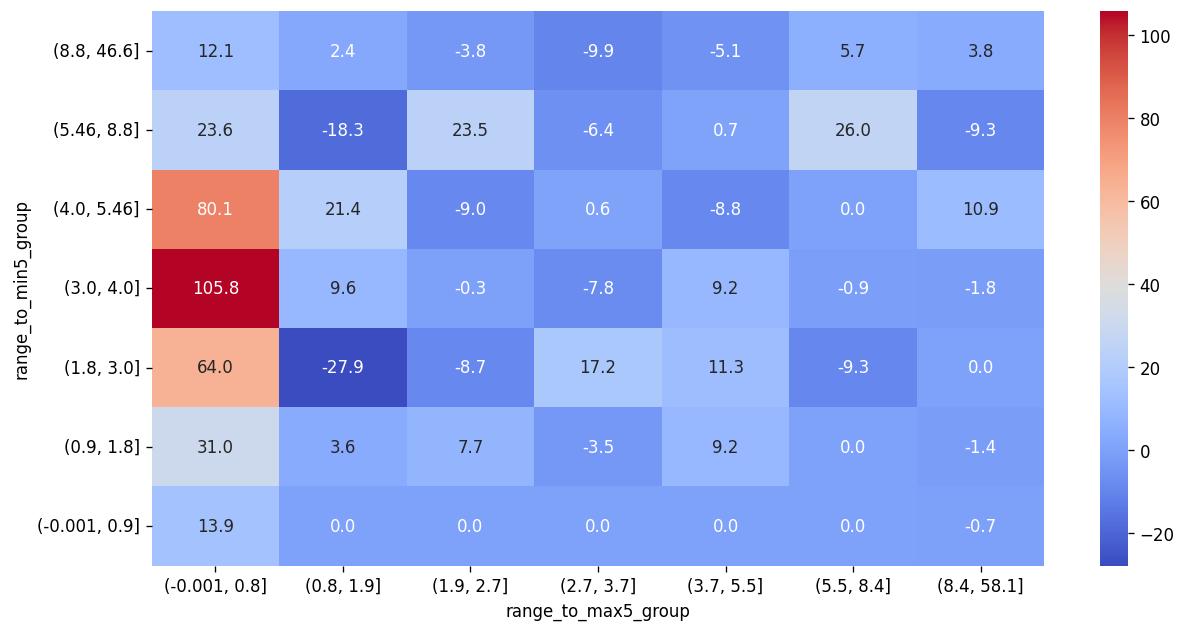

In [73]:
long_grpd_minmax = long_trades.groupby(['range_to_min5_group', 'range_to_max5_group'])[['PnL']]
long_irs_minmax = long_grpd_minmax.sum().reset_index()
sns.heatmap(
    long_irs_minmax.pivot(index='range_to_min5_group', columns='range_to_max5_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True, fmt=".1f");

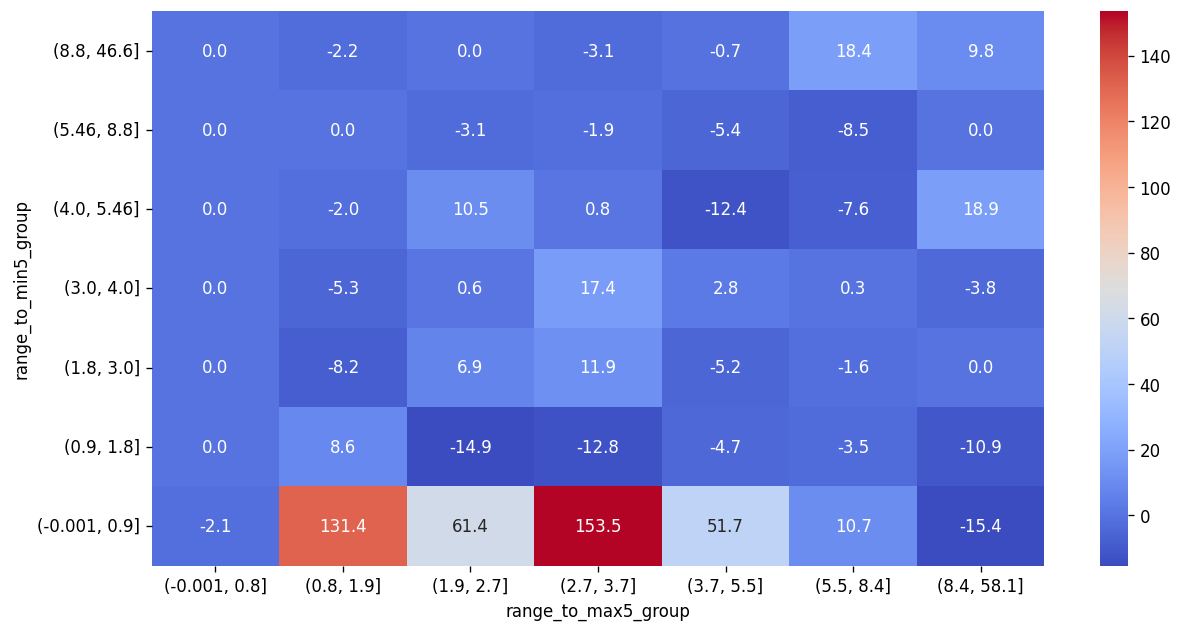

In [74]:
sshort_grpd_minmax = short_trades.groupby(['range_to_min5_group', 'range_to_max5_group'])[['PnL']]
short_irs_minmax = sshort_grpd_minmax.sum().reset_index()
sns.heatmap(
    short_irs_minmax.pivot(index='range_to_min5_group', columns='range_to_max5_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True, fmt=".1f");

## Close - EMA_low difference Ananlytics

<Axes: xlabel='diff_cema'>

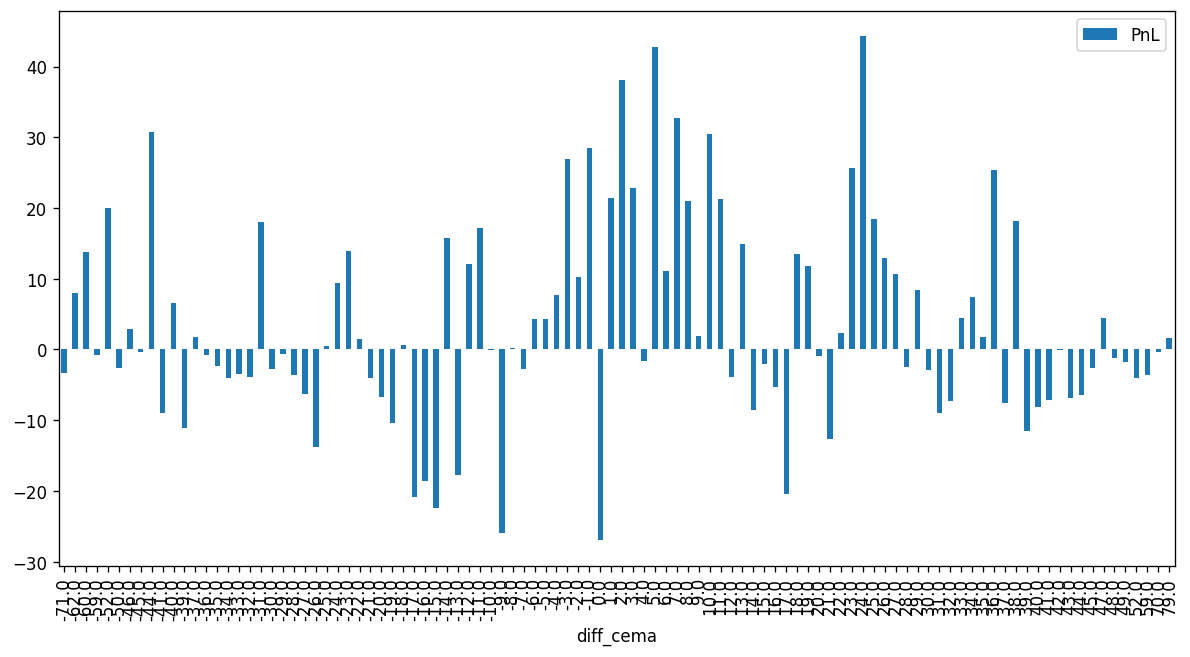

In [29]:
long_trades_grouped_by_diff_cema = long_trades.groupby(['diff_cema'])[['PnL']].sum()
long_trades_grouped_by_diff_cema.plot.bar()

## Price_move analytics

<Axes: xlabel='price_move'>

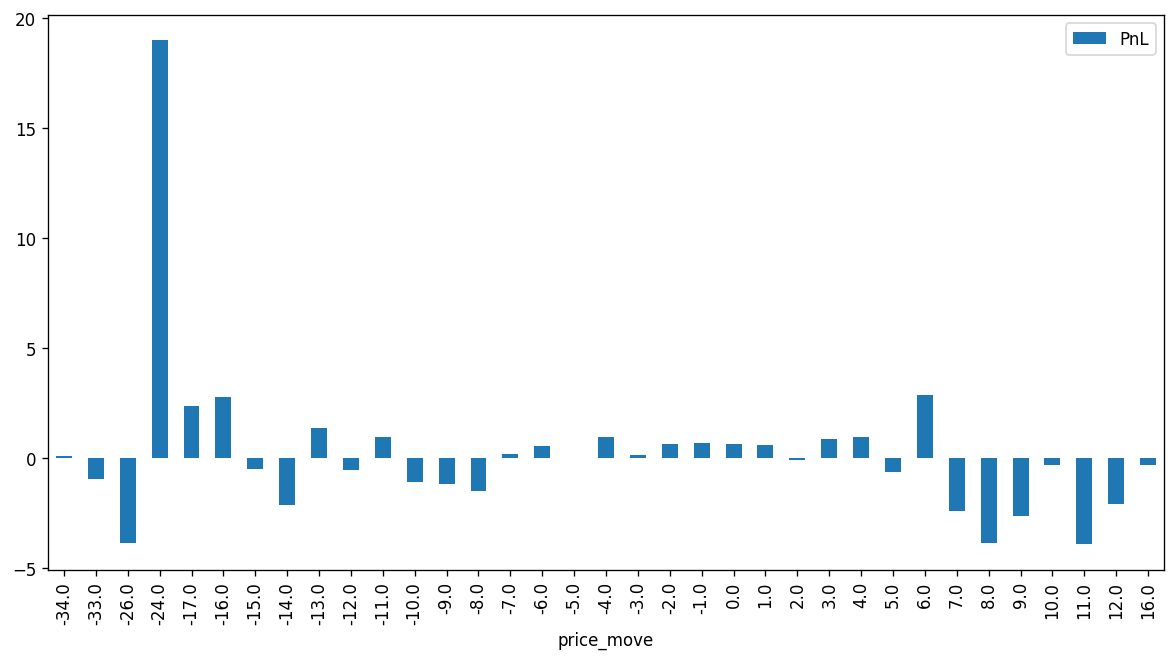

In [30]:
trades_grouped_by_pricemove = join_trades.groupby(['price_move'])[['PnL']].mean()
trades_grouped_by_pricemove.plot.bar()

<Axes: xlabel='price_move'>

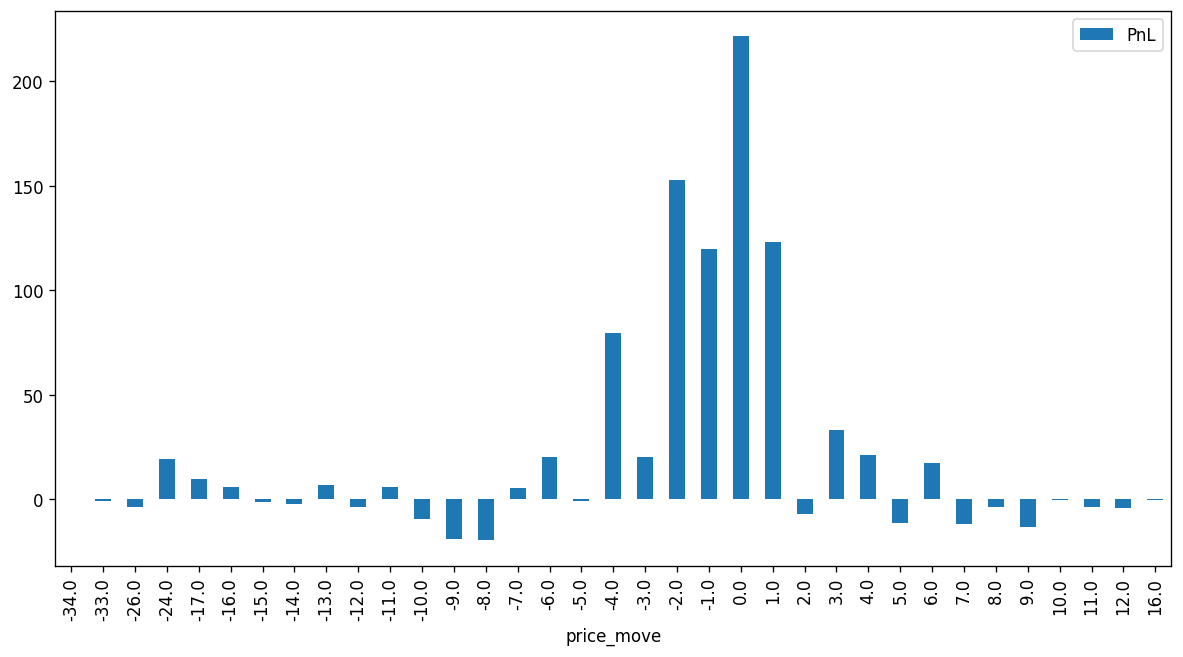

In [31]:
trades_grouped_by_pricemove = join_trades.groupby(['price_move'])[['PnL']].sum()
trades_grouped_by_pricemove.plot.bar()

<Axes: xlabel='price_move'>

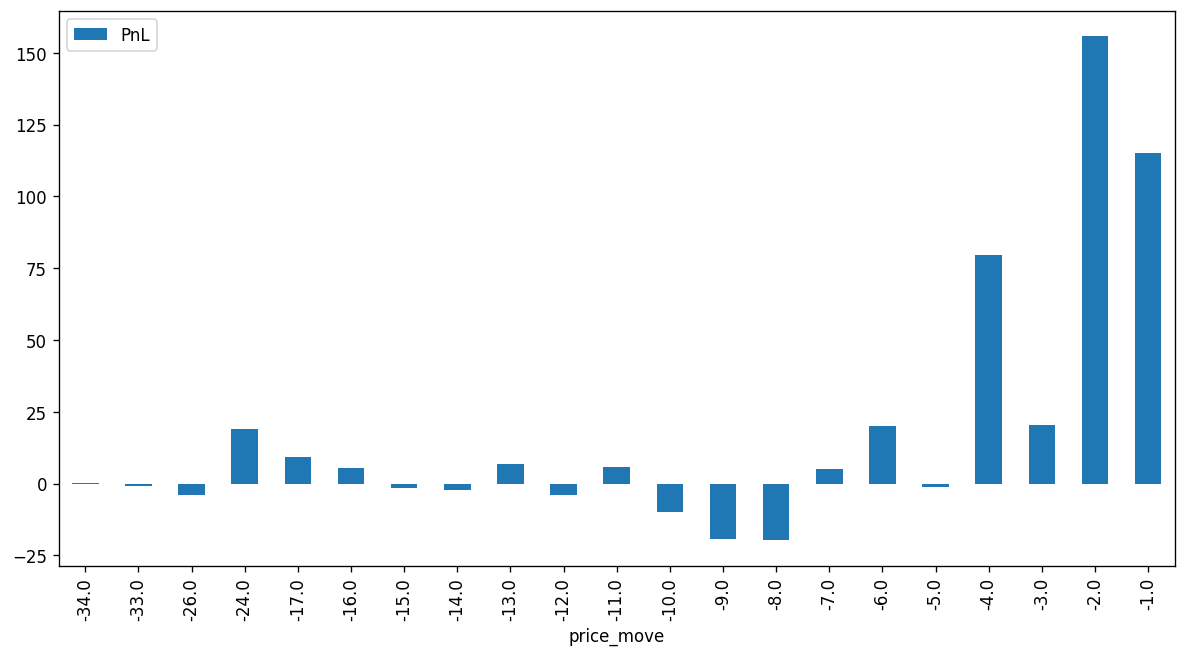

In [32]:
short_trades_grouped_by_pricemove = short_trades.groupby(['price_move'])[['PnL']].sum()
short_trades_grouped_by_pricemove.plot.bar()

<Axes: xlabel='price_move'>

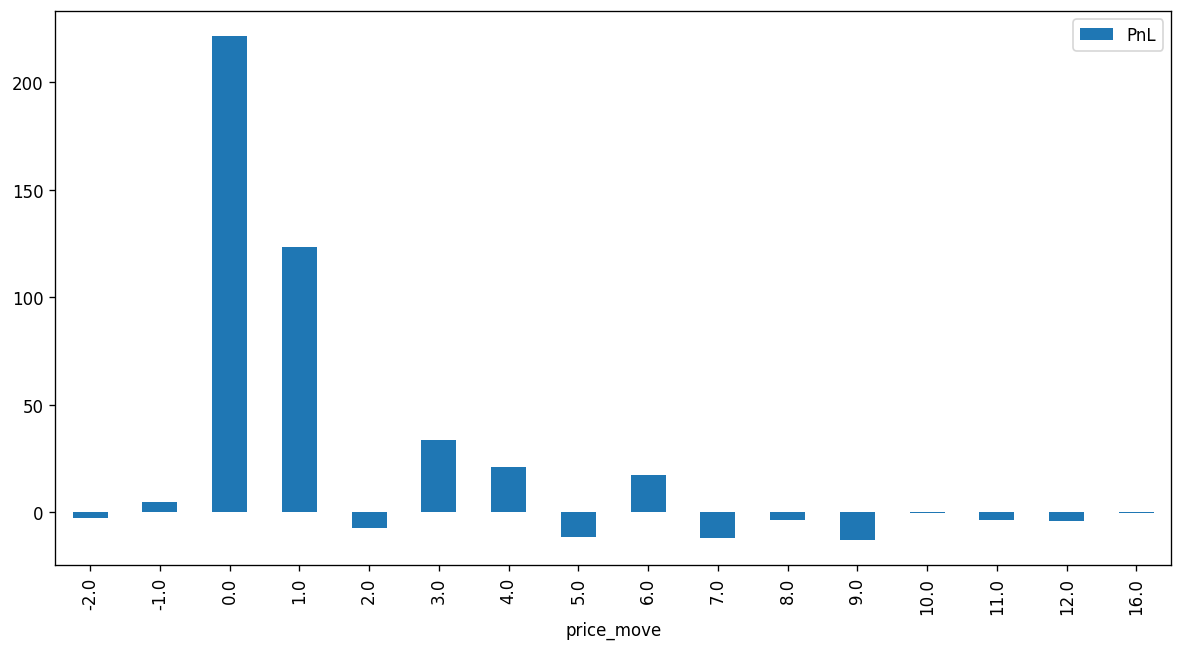

In [33]:
long_trades_grouped_by_pricemove = long_trades.groupby(['price_move'])[['PnL']].sum()
long_trades_grouped_by_pricemove.plot.bar()

Text(0, 0.5, 'PnL')

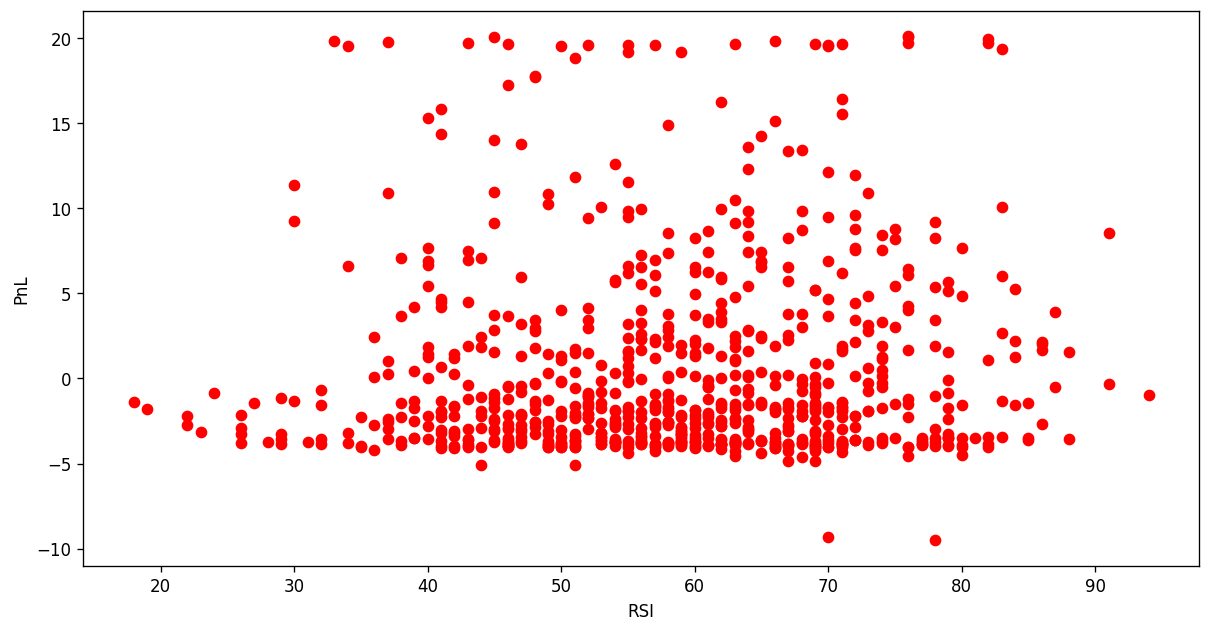

In [34]:
plt.scatter(long_trades['RSI'], long_trades['PnL'], color='red')
plt.xlabel("RSI")
plt.ylabel("PnL")

<Axes: xlabel='RSI'>

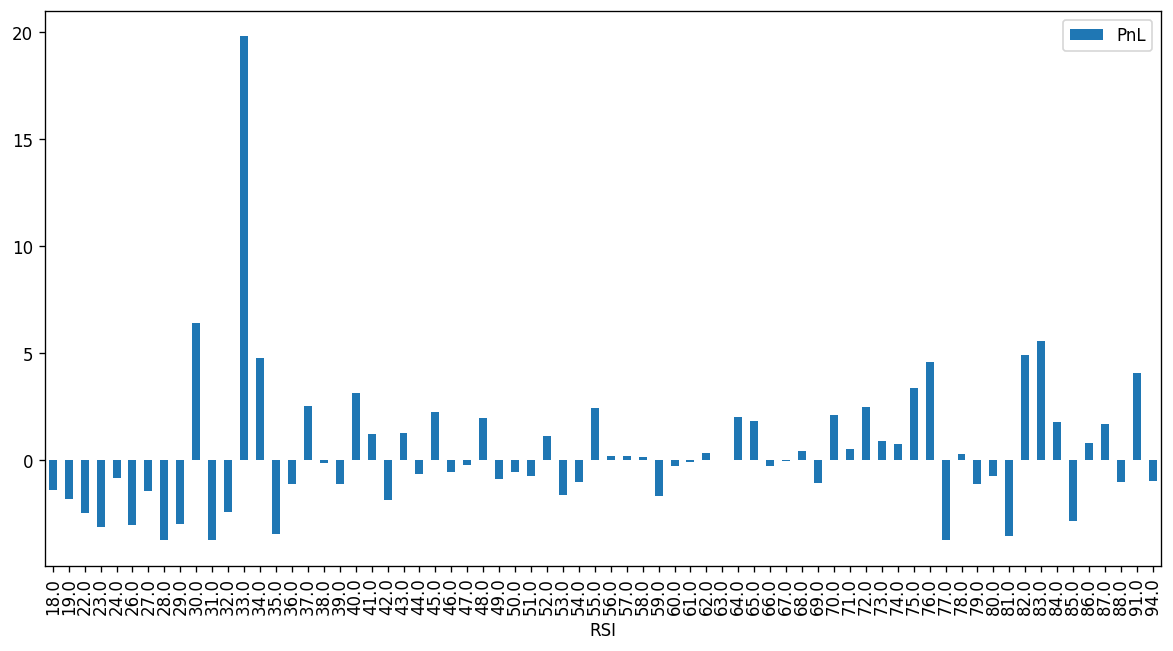

In [35]:
long_trades_grouped_by_rsi = long_trades.groupby(['RSI'])[['PnL']].mean()
long_trades_grouped_by_rsi.plot.bar()

<Axes: xlabel='RSI'>

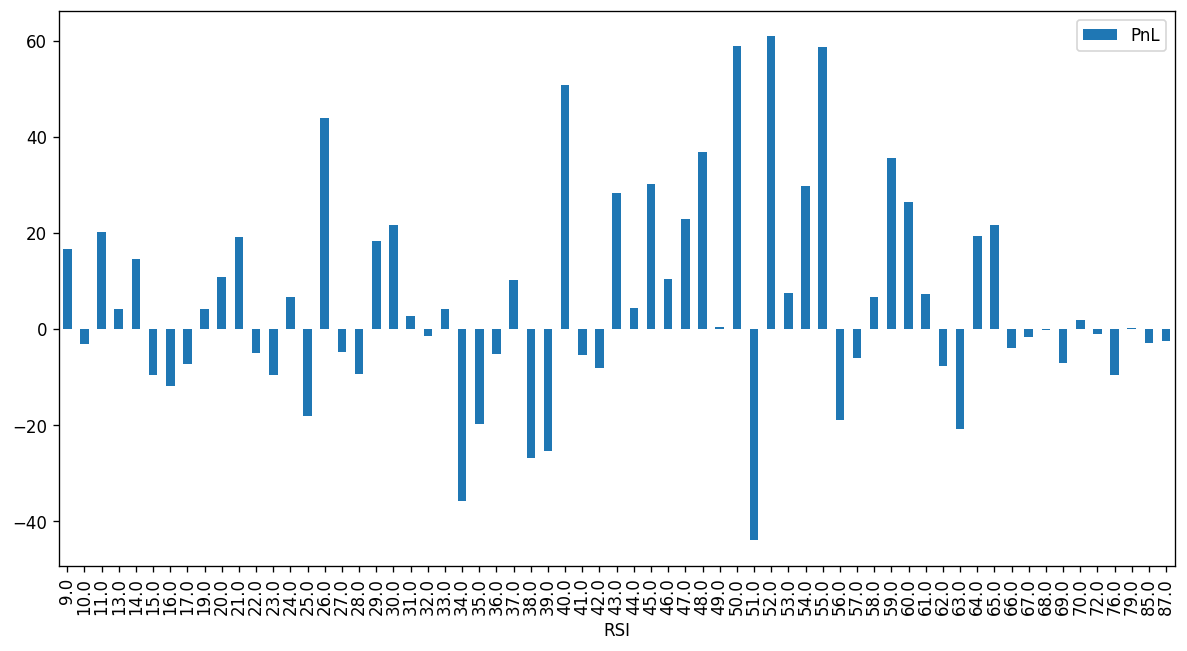

In [36]:
short_trades_grouped_by_rsi = short_trades.groupby(['RSI'])[['PnL']].sum()
short_trades_grouped_by_rsi.plot.bar()

<Axes: xlabel='ADX'>

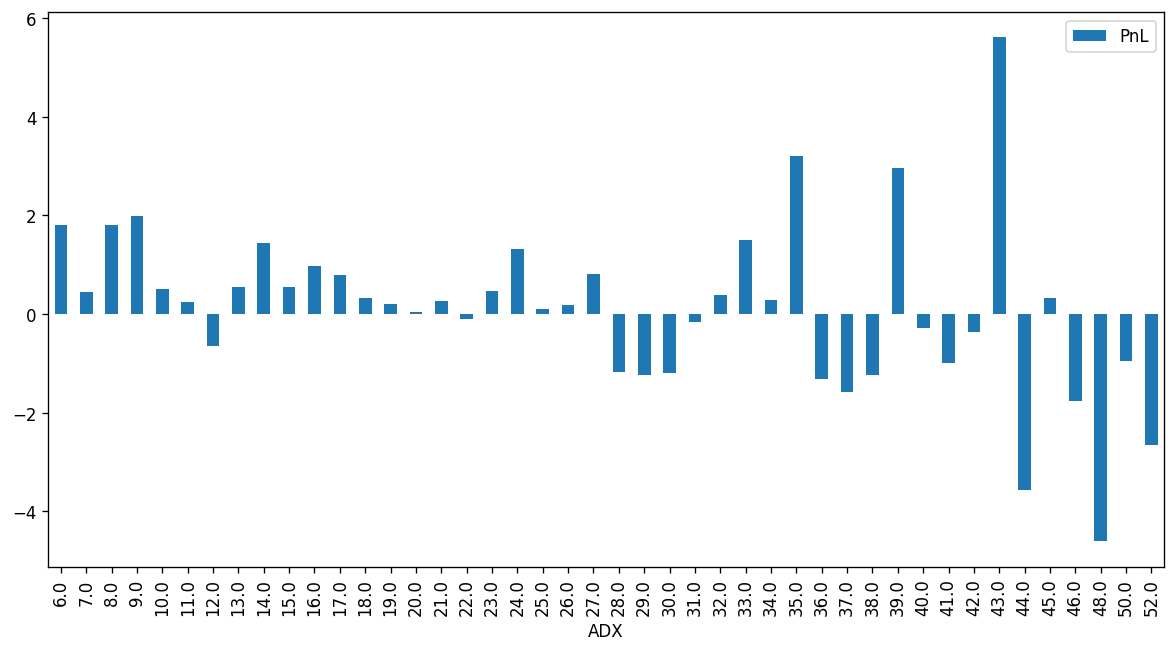

In [37]:
trades_grouped_by_adx = join_trades.groupby(['ADX'])[['PnL']].mean()
trades_grouped_by_adx.plot.bar()

<Axes: xlabel='ADX'>

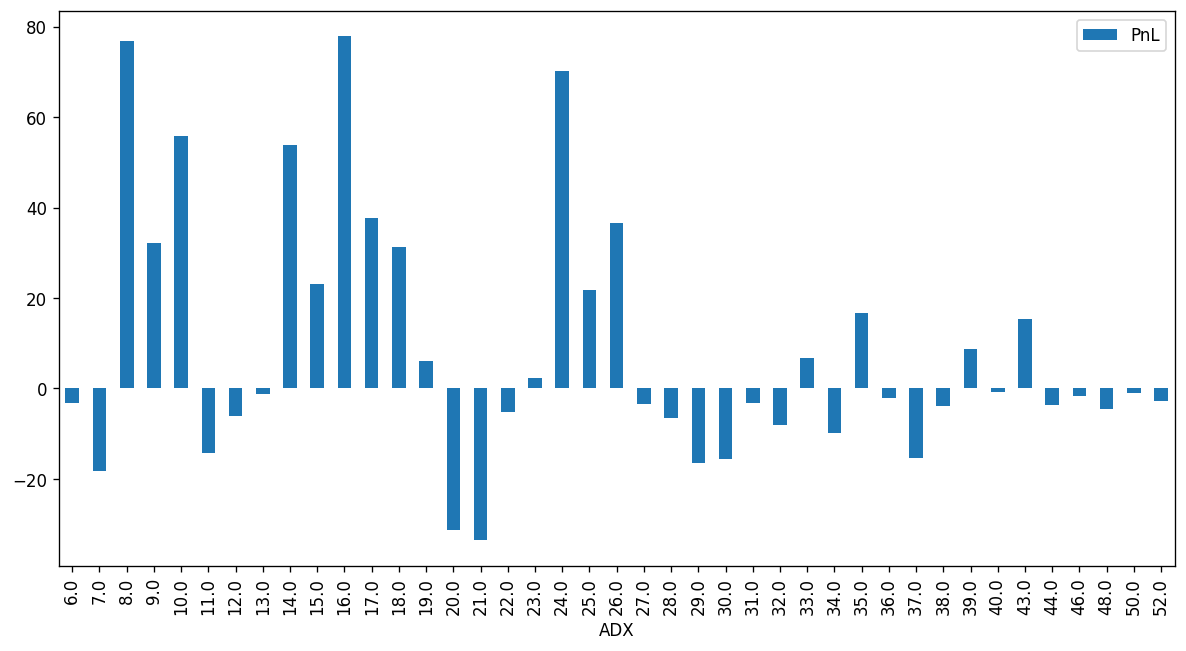

In [38]:
long_trades_grouped_by_adx = long_trades.groupby(['ADX'])[['PnL']].sum()
long_trades_grouped_by_adx.plot.bar()

<Axes: xlabel='ADX'>

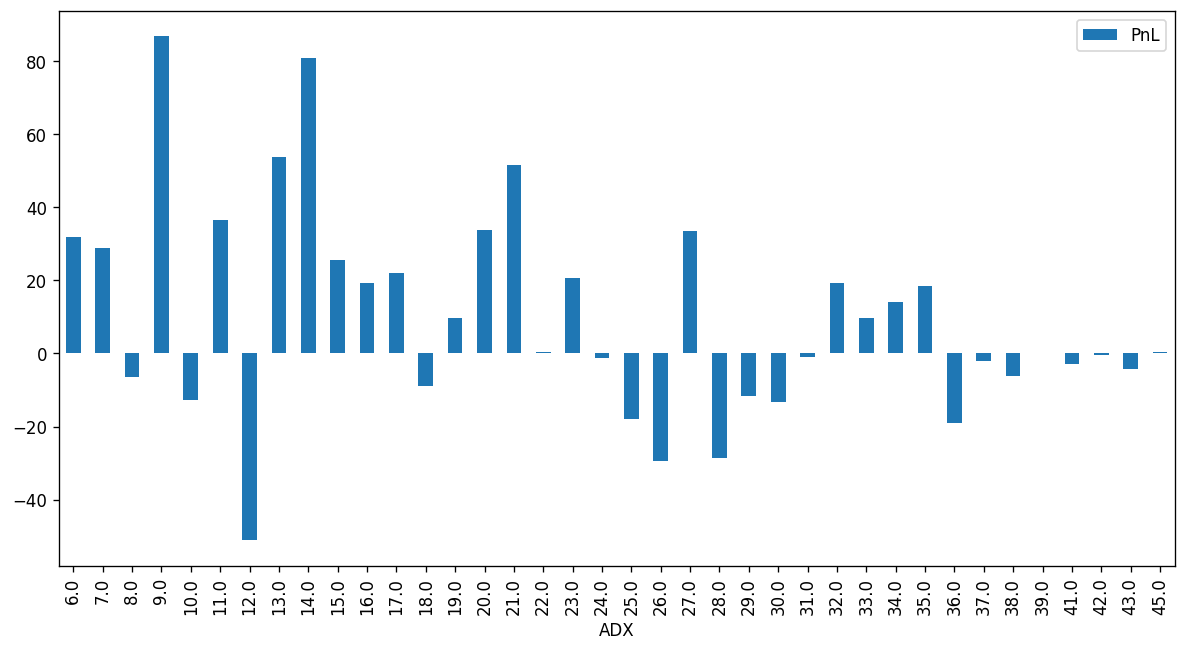

In [39]:
short_trades_grouped_by_adx = short_trades.groupby(['ADX'])[['PnL']].sum()
short_trades_grouped_by_adx.plot.bar()

<Axes: xlabel='ADX'>

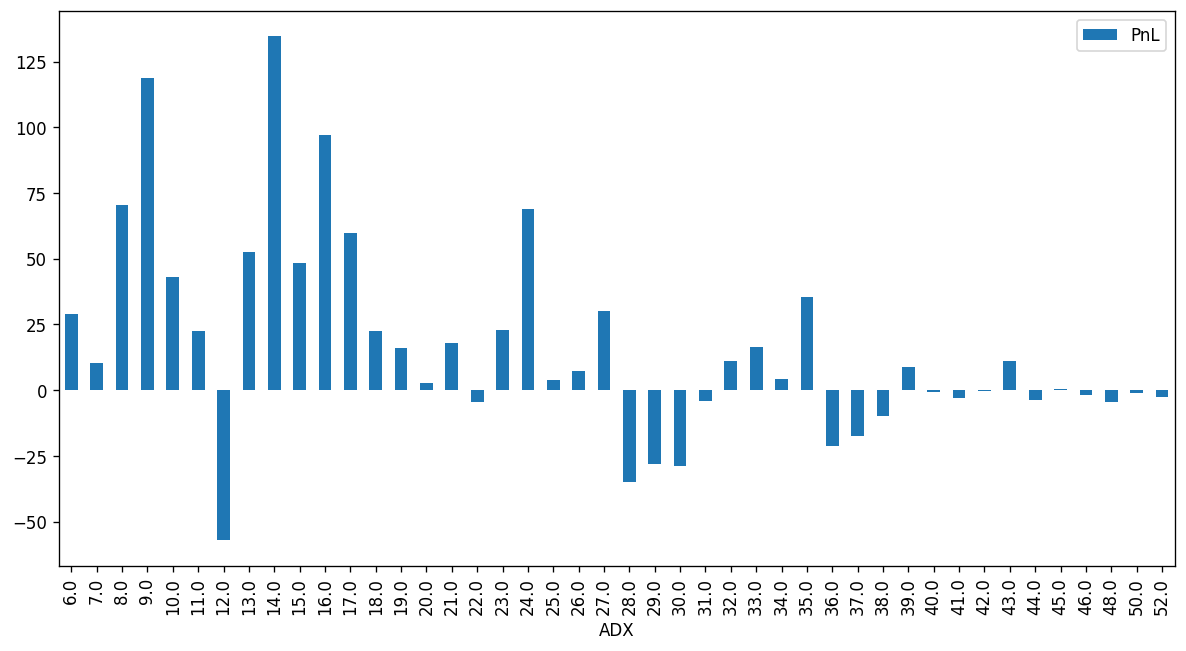

In [40]:
trades_grouped_by_adx_sum = join_trades.groupby(['ADX'])[['PnL']].sum()
trades_grouped_by_adx_sum.plot.bar()

<Axes: xlabel='ADX'>

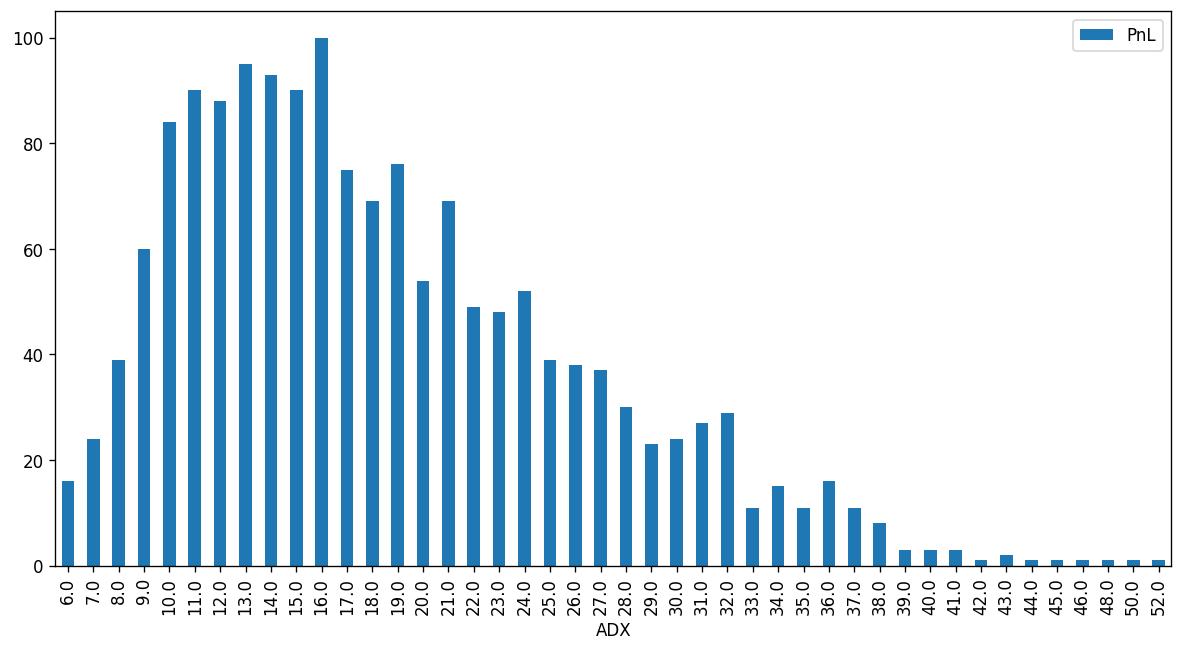

In [41]:
trades_grouped_by_adx_count = join_trades.groupby(['ADX'])[['PnL']].count()
trades_grouped_by_adx_count.plot.bar()